# Notebook per l'esercitazione legata alla lezione 13.

Calcolo delle traiettorie P/T adiabatiche

Il programma è una modifica di *gibbs_tp* già usato nelle esercitazioni precedenti, a cui è stata aggiunta una funzione (*adiabat*) che fa i calcoli rilevanti in questo caso. 

La nuova funzione è riportata nella cella sottostante per chi volesse studiarla. La strategia che segue nel fare i calcoli è descritta nelle ultime slide delle lezioni *termodinamica_13*.

Si tratta di una funzione *apparentemente* complessa perchè deve gestire un input *flessibile* che consenta di trattare sia fasi singole, sia sistemi che includono una reazione e un output diversificato.

Come parametri *obbligatori*, la funzione richiede quelli per la definizione della griglia P/T sulla quale effettuare il calcolo; tutti gli altri argomenti di input sono in forma di keyword e prevedono dei valori di default. Vedremo il loro uso negli esempi sottostanti.

```
def adiabat(tini,tfin,nt,pini,pfin,npp,prod=['py',1], \
            rea=['ens',1.5,'cor', 1], phase='', env=0.,nsamp=0,\
                grd=False, ret=False):
    """
    Computes adiabats on a P/T grid
    
    Input:
        tini, tfin, nt: minimum, maximum and number of points 
                        along the temperature axis
        pini, pfin, npp: minimum, maximum and number of points
                         along the pressure axis
        env: if env > 0., value of the entropy correspondent to wanted
             P/T path (default = 0.)  
        nsamp: if > 0, restricts the number of entries of the printed
               P/T/V list to nsamp values (default = 0.). Relevant if
               env > 0.
        grd: if True, plots the grid of sampling P/T points 
             (default = False)
        prod: list of products of the reaction in the form 
              [name_1, c_name_1, name_2, c_name_2, ...]
              where name_i is the name of the i^th mineral, as stored
              in the database, and c_name_i is the corresponding
              stoichiometric coefficient
        rea:  list of reactants; same syntax as the "prod" list.
        phase: if phase is not '', the computation is done for a single
               (specified) phase (default = '')
        ret: if True, T/P values of the adiabat are returned 
        
    """
    
    phase_flag=False
    if phase !='':
       phase_flag=True
       
    if not phase_flag:   
        lprod=len(prod)
        lrea=len(rea)
        prod_spec=prod[0:lprod:2]
        prod_coef=prod[1:lprod:2]
        rea_spec=rea[0:lrea:2]
        rea_coef=rea[1:lrea:2]
        
        lastr=rea_spec[-1]
        lastp=prod_spec[-1]
        
        prod_string=''
        for pri in prod_spec:
            prod_string=prod_string + pri
            if pri != lastp:
                prod_string=prod_string+' + '
            
        rea_string=''
        for ri in rea_spec:
            rea_string = rea_string + ri
            if ri != lastr:
                rea_string=rea_string+' + '
            
            
    t_list=np.linspace(tini,tfin,nt)
    p_list=np.linspace(pini,pfin,npp)
    tg, pg=np.meshgrid(t_list,p_list)
    
    ntp=nt*npp
    
    tgl=tg.reshape(ntp)
    pgl=pg.reshape(ntp)
    
    ent=np.array([])
    
    if not phase_flag:
        index=0
        for it in tgl:
            ip=pgl[index]
            gprod=0.
            for pri, pci in zip(prod_spec, prod_coef):
                gprod=gprod+(eval(pri+'.g_tp(it,ip)'))*pci
            
            grea=0.
            for ri,rci in zip(rea_spec, rea_coef):
                grea=grea+(eval(ri+'.g_tp(it,ip)'))*rci   
        
            ient=0.
            if gprod < grea:
                for pri, pci in zip(prod_spec, prod_coef):
                    ient=ient+(eval(pri+'.s_tp(it,ip)'))*pci
            else:
                for ri,rci in zip(rea_spec, rea_coef):
                    ient=ient+(eval(ri+'.s_tp(it,ip)'))*rci 
                
            ent=np.append(ent,ient)
            index=index+1  
    else:
        index=0
        for it in tgl:
            ip=pgl[index]
            ient=eval(phase+'.s_tp(it,ip)')
            ent=np.append(ent,ient)
            index=index+1
    
    ent=ent.reshape(npp,nt)
    
    if grd:
       plt.figure()
       plt.scatter(tg,pg,s=20,color='k')
       plt.xlabel("T (K)")
       plt.ylabel("P GPa")
       plt.title("Grid")
       plt.show()
    
    plt.figure()
    if env > 0.:
       con=plt.contour(tg,pg,ent, [env])
       p1=con.collections[0].get_paths()[0]
       path=p1.vertices
    else:
       con=plt.contour(tg,pg,ent)
    
    if env > 0.:
        plt.close()
    else:
        plt.clabel(con, inline=1, fontsize=10)
        plt.xlabel("T (K)")
        plt.ylabel("P (GPa)")
        plt.title("Entropy (J/K mol)")
        plt.show()
    
    if env > 0.:
        t_val=path[:,0]
        p_val=path[:,1]
        plt.figure()
        plt.plot(p_val,t_val)
        plt.ylabel("T (K)")
        plt.xlabel("P (GPa)")
        title="P/T adiabat for an entropy of " + str(env) \
             + " J/(K mol)"
        plt.title(title)
        plt.show()
        
        ipos=p_val.argsort()
        t_val=t_val[ipos]
        p_val=p_val[ipos]
        
        ism=1
        if nsamp > 0:
           lt=len(t_val)
           if lt > nsamp:
              ism=int(lt/nsamp)
         
        t_ret=t_val
        p_ret=p_val
        
        t_val=t_val[0:-1:ism]
        p_val=p_val[0:-1:ism]
        v_val=np.array([])
        
        if not phase_flag:
            index=0
            for it in t_val:
                ip=p_val[index]
                gprod=0.
                ivp=0.
                ivr=0.
                for pri, pci in zip(prod_spec, prod_coef):
                    gprod=gprod+(eval(pri+'.g_tp(it,ip)'))*pci
                    ivp=ivp+(eval(pri+'.volume_p(it,ip)'))*pci
                    
                grea=0.
                for ri,rci in zip(rea_spec, rea_coef):
                    grea=grea+(eval(ri+'.g_tp(it,ip)'))*rci  
                    ivr=ivr+(eval(ri+'.volume_p(it,ip)'))*rci
                    
                index=index+1
                
                if gprod < grea:
                    v_val=np.append(v_val,ivp)
                else:
                    v_val=np.append(v_val,ivr)
        else:
            index=0
            for it in t_val:
                ip=p_val[index]
                iv=eval(phase+'.volume_p(it,ip)')
                v_val=np.append(v_val,iv)
                index=index+1
            
        serie=(p_val.round(2),t_val.round(1),v_val.round(3))
        pd.set_option('colheader_justify', 'center')
        df=pd.DataFrame(serie, index=['P (GPa)','T (K)','Vol (J/bar)'])
        df=df.T
        print("")
        print(df.to_string(index=False))
        
    if env > 0.:
        if ret:
           return t_ret, p_ret

```

### Lanciamo il programma

In [39]:
%matplotlib inline
%run gibbs_tp_adiabat

Per una descrizione dell'input accettato da *adiabat*, si usi il comando *help*

In [40]:
help(adiabat)

Help on function adiabat in module __main__:

adiabat(tini, tfin, nt, pini, pfin, npp, prod=['py', 1], rea=['ens', 1.5, 'cor', 1], phase='', env=0.0, nsamp=0, grd=False, ret=False)
    Computes adiabats on a P/T grid
    
    Input:
        tini, tfin, nt: minimum, maximum and number of points 
                        along the temperature axis
        pini, pfin, npp: minimum, maximum and number of points
                         along the pressure axis
        env: if env > 0., value of the entropy correspondent to the wanted
             P/T path (default = 0.)  
        nsamp: if > 0, restricts the number of entries of the printed
               P/T/V list to nsamp values (default = 0.). Relevant if
               env > 0.
        grd: if True, plots the grid of sampling P/T points 
             (default = False)
        prod: list of products of the reaction in the form 
              [name_1, c_name_1, name_2, c_name_2, ...]
              where name_i is the name of the i^th mine

Cominciamo col dare un'occhiata alle traiettorie P/T adiabatiche dell'enstatite, nell'intervallo di temperatura tra 300 e 1000K e nell'intervallo di pressione tra 0 e 10 GPa; usiamo una risoluzione di 20 punti lungo l'asse delle T e 20 punti lungo l'asse delle P; visualizziamo anche la griglia.

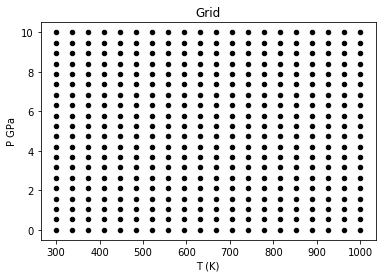

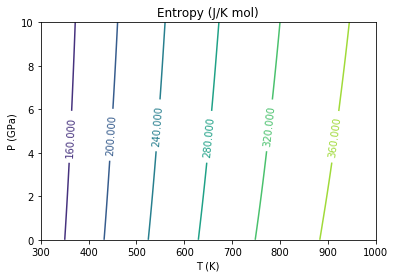

In [9]:
adiabat(300,1000,20,0,10,20,phase='ens',grd=True)

I valori di entropia sono scritti direttamente sulle curve in colore. Possiamo selezionare un valore di entropia compreso tra 160 e 360 J/K mole, volendo i dati relativi a una adiabatica specifica che parta, per, esempio da un certo valore di temperatura. Se poniamo S=310 J/K mole, saremmo in corrispondenza di 700 K a P=0GPa.

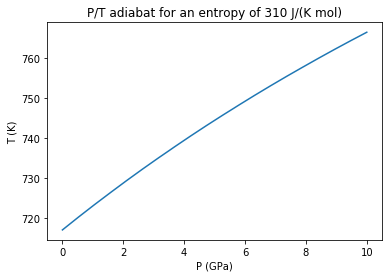


 P (GPa)  T (K)  Vol (J/bar)
  0.00    717.0     6.335   
  1.05    723.3     6.271   
  1.58    726.4     6.240   
  2.63    732.2     6.181   
  3.50    736.8     6.134   
  4.21    740.5     6.097   
  5.26    745.7     6.044   
  5.79    748.2     6.019   
  6.84    753.1     5.969   
  7.89    757.7     5.921   
  8.42    760.0     5.898   
  9.47    764.3     5.853   


In [10]:
adiabat(600,800,20,0,10,20,env=310,phase='ens',nsamp=10)

Notate la diminuzione significativa del volume molare (che è dato in J/bar) all'aumentare della pressione, e il significativo aumento della temperatura (di circa 50 K). La keyword nsamp=10 ha generato una tabella P/T/V di 10 entries. Volendo ottenere in uscita una lista dei valori T/P della traiettoria calcolata (per poi utilizzarla in altra applicazioni), specificare la keyword ret=True: 

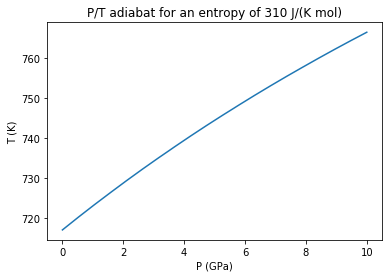


 P (GPa)  T (K)  Vol (J/bar)
  0.00    717.0     6.335   
  1.05    723.3     6.271   
  1.58    726.4     6.240   
  2.63    732.2     6.181   
  3.50    736.8     6.134   
  4.21    740.5     6.097   
  5.26    745.7     6.044   
  5.79    748.2     6.019   
  6.84    753.1     5.969   
  7.89    757.7     5.921   
  8.42    760.0     5.898   
  9.47    764.3     5.853   


In [11]:
t,p=adiabat(600,800,20,0,10,20,env=310,phase='ens',nsamp=10,ret=True)

Per esempio i valori di T sono adesso salvati nella variabile *t*:

In [13]:
print(t)

[717.01765763 720.21818027 723.32884084 726.31578947 726.35385182
 729.32788264 732.22187011 735.03903214 736.84210526 737.7924614
 740.49344292 743.12541783 745.69098664 747.36842105 748.20128889
 750.66694341 753.07251126 755.42012301 757.71180409 757.89473684
 759.97073432 762.17877866 764.33580895 766.44350969]


Consideriamo adesso l'esempio che trovate nelle slide in *termodinamica_13*: la reazione ens+cor <--> py. 

In tal caso dobbiamo specificare la liste dei prodotti (py) e dei reagenti (ens, cor) insieme ai rispettivi coefficienti stechiometrici (1 per py; 1.5 per ens e 1 per cor). La sintassi è 

```
prod=['py',1], rea=['ens',1.5,'cor',1]

```

e quindi:

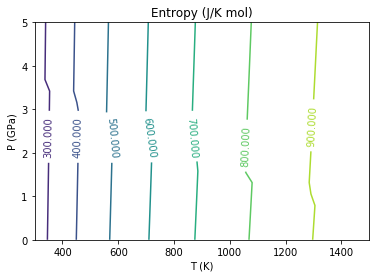

In [14]:
adiabat(300,1500,20,0,5,20,prod=['py',1],rea=['ens',1.5,'cor',1])

Notate le discontinuità sulle curve a entropia costante, dovute alla reazione (a basse pressioni abbiamo ens+cor; ad alte pressioni abbiamo py). Questa reazione è confermata da:


  T (K)  P (GPa)  DH(J/mol)  DS (J/mol K)  DV (J/bar)  Slope (bar/K)
  300.0   3.67     5304.500     17.682       -0.527       -33.54    
  409.1   3.31     7325.018     17.906       -0.539       -33.20    
  518.2   2.95     9215.754     17.785       -0.552       -32.20    
  627.3   2.61    10811.291     17.235       -0.566       -30.45    
  736.4   2.29    12066.310     16.386       -0.580       -28.26    
  845.5   1.99    12975.214     15.347       -0.594       -25.85    
  954.5   1.72    13547.235     14.192       -0.607       -23.36    
 1063.6   1.48    13797.264     12.972       -0.621       -20.89    
 1172.7   1.27    13742.094     11.718       -0.634       -18.48    
 1281.8   1.08    13398.789     10.453       -0.647       -16.15    
 1390.9   0.91    12783.963      9.191       -0.660       -13.93    
 1500.0   0.77    11913.469      7.942       -0.672       -11.82    




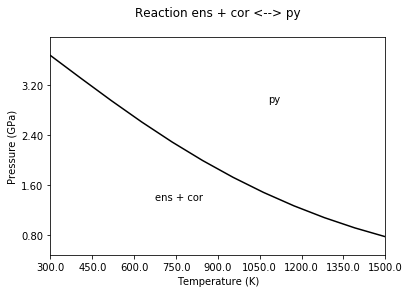


Average Clapeyron Slope (from Delta S/Delta V): -24.01 bar/K
Clapeyron slope (from a linear fit of the P/T curve): -24.32 bar/K


In [15]:
equilib(300,1500,12,prod=['py',1],rea=['ens',1.5,'cor',1])

Concentriamoci nell'adiabatica a S=700 J/K mole:

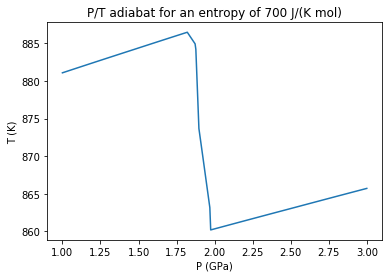


 P (GPa)  T (K)  Vol (J/bar)
  1.00    881.1    12.041   
  1.21    882.5    12.020   
  1.41    883.8    11.999   
  1.56    884.8    11.984   
  1.77    886.2    11.964   
  1.90    873.7    11.947   
  2.03    860.5    11.336   
  2.23    861.6    11.322   
  2.44    862.7    11.309   
  2.59    863.5    11.299   
  2.79    864.6    11.285   


In [17]:
adiabat(800,1000,20,1,3,40,prod=['py',1],rea=['ens',1.5,'cor',1],env=700,nsamp=10)

Come spiegato nelle slide, il salto *negativo* di temperatura (da circa 886 K prima della reazione, a circa 860 K dopo la reazione) è dovuto al fatto che il $\Delta H$ di reazione è positivo (reazione *endotermica*) che assorbe calore e quindi, in una adiabatica, la temperatura diminuisce. Parimenti, il salto *negativo* di volume (da circa 11.95 a 11.34 J/bar) in prossimità della zona di reazione (circa 2 GPa a 860 K) è dovuto al fatto che il volume molare del piropo è più basso di quello della miscela 1.5 enstatite + corindone.

Esaminiamo ancora il caso della transizione quarzo/coesite. Preliminarmente, usiamo *equilib* per determinare un campo P/T conveniente per studiare la transizione:


  T (K)  P (GPa)  DH(J/mol)  DS (J/mol K)  DV (J/bar)  Slope (bar/K)
  300.0   2.89    -303.957      -1.013       -0.181        5.61     
  363.6   2.93    -285.275      -0.785       -0.180        4.37     
  427.3   2.95    -253.669      -0.594       -0.178        3.33     
  490.9   2.97    -221.092      -0.450       -0.177        2.54     
  554.5   2.98    -192.284      -0.347       -0.176        1.97     
  618.2   2.99    -168.734      -0.273       -0.175        1.56     
  681.8   3.00    -150.380      -0.221       -0.174        1.27     
  745.5   3.01    -136.402      -0.183       -0.173        1.06     
  809.1   3.02    -125.617      -0.155       -0.172        0.90     
  872.7   3.02    -116.679      -0.134       -0.170        0.78     
  936.4   3.03    -108.192      -0.116       -0.169        0.68     
 1000.0   3.03     -98.762      -0.099       -0.168        0.59     




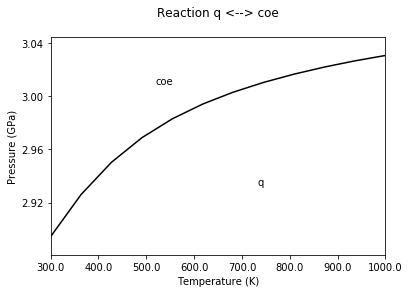


Average Clapeyron Slope (from Delta S/Delta V):   2.06 bar/K
Clapeyron slope (from a linear fit of the P/T curve):   1.78 bar/K


In [18]:
equilib(300,1000,12,prod=['coe',1],rea=['q',1])

Eseguiamo quindi un calcolo di adiabatica:

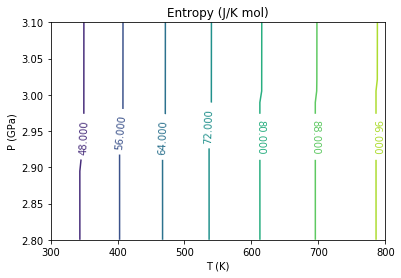

In [20]:
adiabat(300,800,20,2.8,3.1,20,prod=['coe',1],rea=['q',1])

e focalizziamoci sull'adiabatica a S=56 J/K mole. 

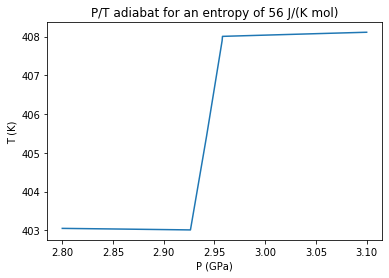


 P (GPa)  T (K)  Vol (J/bar)
  2.80    403.0     2.191   
  2.83    403.0     2.190   
  2.86    403.0     2.189   
  2.89    403.0     2.188   
  2.93    403.0     2.188   
  2.96    407.9     2.008   
  2.97    408.0     2.008   
  3.01    408.0     2.007   
  3.04    408.1     2.007   
  3.07    408.1     2.006   


In [21]:
adiabat(350,450,20,2.8,3.1,20,prod=['coe',1],rea=['q',1],env=56,nsamp=10)

Poichè si tratta di una transizione esotermica ($\Delta H$ è negativo come si vede dall'output di *equilib*), alla pressione di transizione abbiamo un aumento di temperatura.

Come considerazione finale, discutiamo il modo attraverso il quale l'entropia viene determinata a ogni valore di pressione e temperatura. Come detto nelle slide, *S* è calcolata dalla derivata parziale di *G* rispetto a *T*, a pressione costante:

$$S=-\left(\frac{\partial G}{\partial T}\right)_P$$

In effetti, mentre a pressione ambiente, l'entropia può essere ottenuta direttamente per integrazione su $T$ di $C_P(T)/T$, dove $C_P$ è il calore specifico a pressione (ambiente) costante, a più alte pressioni questa via non può essere seguita (appunto perchè non disponiano del $C_P$ misurato in alta pressione). 

La funzione *s_tp* della classe *mineral* calcola l'entropia a qualunque $T$ e $P$ appunto usando la derivata di $G$ rispetto a $T$:

```
    def s_tp(self,tt,pp):
        gtp=lambda tf: self.g_tp(tf,pp)
        t_list=np.linspace(tt-5, tt+5, 5)
        g_list=np.array([])
        for ti in t_list:
            gi=gtp(ti)
            g_list=np.append(g_list,gi)
        fit=np.polyfit(t_list,g_list,2)
        fitder=np.polyder(fit,1)
        return -1*np.polyval(fitder,tt)

```

La funzione *s_tp*:

- definisce preventivamente una funzione *lambda* (si tratta di una funzione *anonima*) assegnata alla variabile *gtp* (che diventa una funzione a tutti gli effetti, che accetta come argomento un valore di temperatura); *gtp* calcola l'energia libera $G$ alle condizioni T/P specificate come argomenti di *s_tp*;
- costruisce una lista *t_list* di 5 valori di temperatura centrati sul valore *tt* voluto;
- si calcola le energie libere corrispondenti ai diversi valori di temperatura in *t_list*, alla pressione *pp* specificata, e le pone in una lista *g_list*;
- esegue un fit polinomiale di secondo grado sulle liste *t_list* e *g_list* $[g(t)=at^2+bt+c]$ e pone i coefficienti ottimizzati ($a,b,c$) nella lista *fit*, usando la funzione *polyfit* di Numpy (*np.polyfit*);
- esegue la derivata del polinomio quadratico, usando la funzione *polyder* di Numpy (specificando la *derivata prima*) e pone i coefficienti nella lista *fitder*;
- restituisce il valore delle derivata (cambiata di segno) valutata alla temperatura voluta (*tt*), usando la funzione *polyval* di Numpy, che corrisponde all'entropia.

Proviamo a fare a mano il calcolo per il piropo; per esempio, a T=500 K, e P=3 GPa, dovremmo ottenere:

In [26]:
py.s_tp(500,3).round(3)

453.427

Vediamo di ottenere *manualmente* questo valore, lavorando come *s_tp*:

In [27]:
t_list=np.linspace(495,505,5)    # lista dei valori di temperatura
g_list=np.array([])              # inizializziamo la lista g_list
for it in t_list:                # ciclo sui valori di temperatura
    ig=py.g_tp(it,3)             # calcolo della G ad ogni T in t_list e P=3GPa
    g_list=np.append(g_list,ig)  # aggiungiamo i valori di G alla lista g_list

Vediamo le due liste:

In [29]:
print(t_list)
print(g_list)

[495.  497.5 500.  502.5 505. ]
[-5668080.99748005 -5669206.74777866 -5670337.72064672 -5671473.89873853
 -5672615.26479645]


Facciamone un plot:

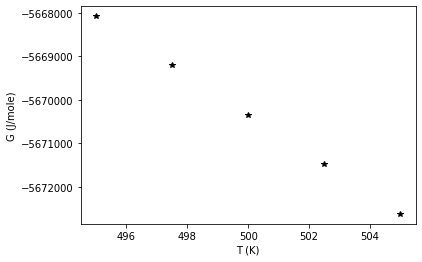

In [32]:
plt.figure()
plt.plot(t_list,g_list,"k*")
plt.xlabel("T (K)")
plt.ylabel("G (J/mole)")
plt.show()

Determiniamo il polinomio quadratico $G(T)$:

In [33]:
fit=np.polyfit(t_list,g_list,2)
print(fit)

[-4.16419913e-01 -3.70075109e+01 -5.54772899e+06]


Già che ci siamo, controlliamo graficamente la qualità del fit:

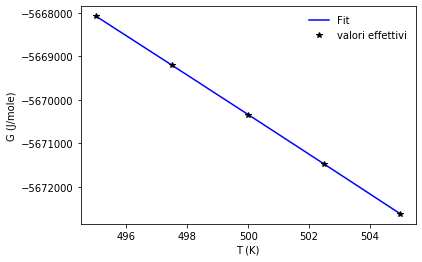

In [35]:
x_list=np.linspace(495,505,20)
y_list=np.polyval(fit,x_list)
plt.figure()
plt.plot(x_list,y_list,"b-",label="Fit")
plt.plot(t_list,g_list,"k*",label="valori effettivi")
plt.legend(frameon=False)
plt.xlabel("T (K)")
plt.ylabel("G (J/mole)")
plt.show()

Facciamo la derivata prima del polinomio:

In [36]:
fitder=np.polyder(fit,1)

Calcoliamo la derivata a T=500K (cambiata di segno):

In [37]:
S=np.polyval(fitder,500)
print("Entropia %6.3f (J/K mole)" % S)

Entropia -453.427 (J/K mole)


Come vedete, il valore è identico a quello calcolato direttamente con la funzione *s_tp* (vuol dire che non abbiamo fatto errori...). Del resto, l'ho scritta io quella funzione perchè facesse i calcoli che abbiamo visto *manualmente*... quindi è ovvio che i risultati siano identici...

<b>Sappiate che potete dire di aver capito veramente tutto di un dato problema solo nel momento in cui siate in grado di fare i calcoli numerici per risolverlo (conoscere solo la teoria, a livello simbolico, non è garanzia di *comprensione*) e, soprattutto siate anche in grado di codificare il calcolo in un programma scritto in qualche linguaggio.</b>  

Gli algoritmi che vediamo in questi programmi ed esercitazioni, sono gli stessi di quelli implementati (in linguaggio *Fortran*) nel programma [Perplex](http://www.perplex.ethz.ch/) che è usato professionalmente da chiunque nel mondo si occupi di metamorfismo o, più in generale, di modellizzazione termodinamica di crosta e mantello terrestre. Più avanti vedremo anche l'uso di Perplex: i numeri che otterrete usando quel programma coincidono all'ultima cifra decimale con quelli che calcoliamo con questi progrtammi Python (ovviamente, a patto di utilizzare gli stessi database termodinamici per $C_P$, $K$, $\alpha$, $G_0$, $S_0$ e $V_0$ di ogni fase minerale). 

Conoscere gli algoritmi attraverso i quali vengono fatti i calcoli, ed essere addirittura in grado di riprodurli indipendentemente, vi dà non una, ma due marce in più di chi usi quegli stessi programmi a *scatola chiusa*, conoscendone solo approssimativamente la termodinamica implicata e ancor meno il modo con cui questa è implementata. Saper fare i calcoli vi rende consapevoli anche dei *limiti* degli stessi, che dipendono dalle *approssimazioni*, dalle *assunzioni* fatte per poterli eseguire, e dalla *qualità* dei dati termodinamici di base contenuti nei database, che potete anche giudicare in modo *critico*.    